# Analysis of withdrawal apply rules

Obtain as many rules as possible, and as many useful rules as possible. 

1. Try to make it work alone so that you can get >8% dispute rate
2. Generate as many rules that give you >4% as possible   

# Individual rules generation

This is the base dataset that we will work with: http://td.winnerstudio.vip:8996/#/tga/ide/59_28259

What I want to check is: 

1. If someone with different succeful rates in terms of withdrawals get to significant levels for their dispute rate 
2. If someone has been a long time without being accepted a withdrawal and different times since then
3. If someone has long time being without being accepted any payment 
4. Maybe you can also check different applied times 



In [ ]:
# 1. Load modified payment-withdrawal query to include the key predictors 

# 2. Do the processing (Now also onto the new columns)

# 3. 

# Setup code

In [1]:
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import random
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
np.random.seed(0)

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import _tree
from tqdm import tqdm

In [2]:
bs_token = 'lWYPGrEyZ0xqY7CJGTMx3DP60VBxZ21v7yrHjKguyGtQY2C5z16og6N8zu0R4Mbw'
host = 'td.winnerstudio.vip'

def pull_data(sql_script, bs_token, host):
    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 2000,
        'sql':            sql_script
    }
    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)
    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]
    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
    # Create a pandas DataFrame
    data = pd.DataFrame(dict_list).sort_index(axis = 1)
    return data


In [3]:
def extract_within_hours(withdraw_times, first_pay_time, hours):
    # Convert withdraw_times to datetime
    withdraw_times_dt = pd.to_datetime(withdraw_times)
    
    # Convert first_pay_time to datetime (if it's not already)
    first_pay_time_dt = pd.to_datetime(first_pay_time)
    
    # Calculate the end time for comparison
    end_time = first_pay_time_dt + pd.Timedelta(hours=hours)
    
    # Return indexes where withdraw_times_dt is within the specified hours
    return [i for i, time in enumerate(withdraw_times_dt) if time <= end_time]

def extract_within_hours(withdraw_times, first_pay_time, hours):
    # Convert withdraw_times to datetime
    withdraw_times_dt = pd.to_datetime(withdraw_times)
    
    # Convert first_pay_time to datetime (if it's not already)
    first_pay_time_dt = pd.to_datetime(first_pay_time)
    
    # Calculate the end time for comparison
    end_time = first_pay_time_dt + pd.Timedelta(hours=hours)
    
    # Return indexes where withdraw_times_dt is within the specified hours
    return [i for i, time in enumerate(withdraw_times_dt) if time <= end_time]

def sum_withdraws_within_hours(withdraw_history, indexes):
    withdraw_history = str(withdraw_history).strip('[]')
    withdraw_values_list = [str(item.strip()) for item in withdraw_history.split(',')]
    
    # Ensure all values are numeric and calculate sum for selected indexes
    selected_withdraws = [float(withdraw_values_list[i].replace('[', '').replace(']', '')) for i in indexes 
                            if i < len(withdraw_values_list) 
                            and withdraw_values_list[i] is not None 
                            and withdraw_values_list[i].replace('[', '').replace(']', '') != ''
                            and withdraw_values_list[i].replace('[', '').replace(']', '') != '.']
    
    return sum(selected_withdraws)

def max_payments_in_window(payment_times, window_minutes):
    max_count = 0
    payment_times = pd.to_datetime(payment_times)
    for i, start_time in enumerate(payment_times):
        end_time = start_time + pd.Timedelta(minutes=window_minutes)
        count = np.sum((payment_times >= start_time) & (payment_times <= end_time))
        if count > max_count:
            max_count = count
    return max_count

def extract_second_payment(x):
    # Remove brackets and replace 'null' with 'NaN'
    cleaned = x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')
    # Check if there is a second element
    if len(cleaned) > 1:
        return float(cleaned[1])
    else:
        return np.nan
    
def extract_third_payment(x):
    # Remove brackets and replace 'null' with 'NaN'
    cleaned = x.replace('[', '').replace(']', '').replace('null', 'NaN').split(',')
    # Check if there is a second element
    if len(cleaned) > 1:
        return float(cleaned[2])
    else:
        return np.nan

def calculate_minutes_diff(start, end):
    if pd.notna(start) and pd.notna(end):
        return (end - start).total_seconds() / 60.0
    else:
        return np.nan

def get_unique_values(lst):
    return list(set(lst))

def extract_datetime(x, index):
    dates = x  # Convert JSON string to list
    if len(dates) > index:
        return pd.to_datetime(str(dates[index])[1:-1])
    else:
        return np.nan

# General function to sum payments within specified hours using the extracted indexes
def sum_payments_within_hours(payment_history, indexes):
    payment_history = str(payment_history).strip('[]')
    payment_values_list = [str(item.strip()) for item in payment_history.split(',')]
    selected_payments = [float(payment_values_list[i].replace('[', '').replace(']', '')) for i in indexes 
                            if i < len(payment_values_list) 
                            and payment_values_list[i] is not None 
                            and payment_values_list[i].replace('[', '').replace(']', '') != ''
                            and payment_values_list[i].replace('[', '').replace(']', '') != '.']
    
    return sum(selected_payments)

# Function to convert the string list to a list of datetime objects
def convert_to_datetime_list(string):
    string = str(string).strip('[]').replace("'", '"').replace('"', '').replace(" 2023", '2023').replace(" 2024", '2024').replace("     2023", '2023')

    string = string.strip()
    date_strs = string.split(',')
    date_strs = [date_str.strip() for date_str in date_strs]
    return pd.to_datetime(date_strs, format='%Y-%m-%d %H:%M:%S.%f')

# Define the model 
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe

def traverse_tree(tree, node_id = 0, depth = 0, dataset = None, path = None):

    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Disputer rate"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right) 
        # print('function here is okay')    
    
    else:
        leaf_size = np.sum(tree.value[node_id])
        # print('leaf_size', leaf_size)
        # print('else here is okay')
        # print(len(tree.value[node_id][0]))
        if len(tree.value[node_id][0]) > 1: 
            true_cases = tree.value[node_id][0][1]
        else: 
            true_cases = 0
        # print('else here is okay oh oh')
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        # print('有问题')
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Disputer rate": [proportion_true],
                                                    "Payers": [leaf_size], "Disputers": [true_cases]})], ignore_index=True)

    return dataset


# Load dispute and payment data

In [4]:
day = 7
version = 1

final_query = f"""
select * 
from temp.payments_d{day}_v{version} a
    -- join temp.games_d{day}_v{version} b    on a."#account_id" = b."#account_id"
"""

reaction_query = "losses_reaction_query"
print(final_query)



select * 
from temp.payments_d7_v1 a
    -- join temp.games_d7_v1 b    on a."#account_id" = b."#account_id"



In [5]:
df = pull_data(final_query, bs_token, host)
print(df.columns)
df.sample(5)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)
Index(['#account_id', 'already_disputed', 'bundle_id', 'disputable_payment',
       'disputed_amount_d30', 'disputes_d30', 'first_dispute_time',
       'first_pay_time', 'hours_first_payment', 'payment_d7',
       'payment_enter_history', 'payment_history', 'payment_history_time',
       'payment_methods_score', 'payment_methods_sequence', 'withdraw_history',
       'withdraw_history_time'],
      dtype='object')


,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,payment_enter_history,payment_history,payment_history_time,payment_methods_score,payment_methods_sequence,withdraw_history,withdraw_history_time
88217,10627128,0,com.acorncasino.slots,0.0,0.0,0,NaN,2024-04-01 21:12:44.192,0,134.5480,"[default, default, default, start_pack, defaul...","[18.74, 18.74, 18.74, 28.16, 4.61, 4.61, 9.32,...","[2024-04-01 21:12:44.192, 2024-04-01 22:20:48....",1,[checkout_apple_pay],NaN,NaN
149383,40297585,0,com.asselin.luckylegends,0.0,0.0,0,NaN,2024-05-16 00:45:47.169,0,61.3135,"[default, default, default]","[4.6395, 9.379, 47.295]","[2024-05-16 00:45:47.169, 2024-05-16 02:52:42....",1,[checkout_apple_pay],NaN,NaN
47589,10668751,0,com.acorncasino.slots,0.0,0.0,0,NaN,2024-04-14 02:45:35.762,77,4.5100,"[cash_back, default]","[0.842, 3.668]","[2024-04-14 02:45:35.762, 2024-04-15 17:00:58....",1,[checkout_apple_pay],NaN,NaN
121968,40177704,0,com.asselin.luckylegends,0.0,0.0,0,NaN,2024-04-19 19:56:11.875,140,18.7400,[default],[18.74],[2024-04-19 19:56:11.875],1,[checkout_credit_api],NaN,NaN
173332,40282257,0,com.asselin.luckylegends,0.0,0.0,0,NaN,2024-05-12 05:00:35.657,0,4.6395,[default],[4.6395],[2024-05-12 05:00:35.657],1,[checkout_apple_pay],NaN,NaN


In [21]:
# Ensure the times are in datetime format
df['first_dispute_time'] = pd.to_datetime(df['first_dispute_time'])
df['first_pay_time'] = pd.to_datetime(df['first_pay_time'])

# Calculate the 'time to dispute' in hours
df['time_to_dispute'] = (df['first_dispute_time'] - df['first_pay_time']).dt.total_seconds() / 3600

# Keep out information outside the first 7 days
df = df[(df['time_to_dispute'].isnull()) | (df['time_to_dispute'] <= 168)].reset_index(drop = True)
df[['first_pay_time', 'first_dispute_time', 'time_to_dispute']].sample(5)


,first_pay_time,first_dispute_time,time_to_dispute
80680,2024-02-01 02:16:14.186,NaT,NaN
120465,2024-03-11 01:16:58.092,NaT,NaN
26030,2024-05-06 21:32:45.335,NaT,NaN
111538,2024-04-04 11:36:41.623,NaT,NaN
102527,2024-01-05 01:08:51.043,NaT,NaN


In [25]:
df[['first_pay_time', 'first_dispute_time', 'time_to_dispute']].sample(10)

,first_pay_time,first_dispute_time,time_to_dispute
112274,2024-01-07 15:46:07.589,2024-01-09 04:33:03.535,36.782207
115360,2024-05-23 01:58:43.998,NaT,NaN
92607,2024-03-30 16:21:34.133,NaT,NaN
111200,2024-01-15 05:08:41.403,NaT,NaN
12224,2024-06-03 00:04:51.401,NaT,NaN
19839,2024-04-18 02:53:48.457,NaT,NaN
52947,2024-05-20 23:54:21.788,NaT,NaN
92810,2024-06-30 00:36:56.876,NaT,NaN
1038,2024-04-04 17:09:51.782,NaT,NaN
34168,2024-01-06 01:29:29.615,NaT,NaN


# Load withdraw advanced data 

The withdrawn data is stored here: http://td.winnerstudio.vip:8996/#/tga/ide/59_31249

In [26]:
withdraw_query = f"""
select * 
from temp.withdraw_advanced a
"""
print(withdraw_query)

withdraw_query = f"""
select * 
from temp.withdraw_advanced_bundle_adjusted a
"""
print(withdraw_query)



select * 
from temp.withdraw_advanced a


select * 
from temp.withdraw_advanced_bundle_adjusted a



In [233]:
withdraw_df = pull_data(withdraw_query, bs_token, host)
print(withdraw_df.columns)
print(withdraw_df.shape)
withdraw_df.sample(5)

,#account_id,amount,applied_time,output,output_time,withdraw_id
6704,10062516,"[100.0, 46.48, 30.0, 60.0, 65.0, 100.0, 315.0,...","[2024-04-05 04:08:23.762, 2024-03-29 16:13:00....","[withdraw_success, withdraw_success, withdraw_...","[2024-04-06 04:05:09.155, 2024-03-30 13:35:08....","[223105.0, 207651.0, 218646.0, 218809.0, 21813..."
56616,40132869,"[500.0, 400.0, 700.0, 300.0, 400.0, 200.0, 300...","[2024-04-05 17:05:13.473, 2024-05-02 20:46:01....","[withdraw_success, withdraw_success, withdraw_...","[2024-04-06 01:52:07.496, 2024-05-03 02:05:33....","[36964.0, 77372.0, 31956.0, 348769.0, 153910.0..."
33734,10229355,"[1.65, 1.0]","[2024-02-16 16:09:17.862, 2024-02-16 16:08:54....","[withdraw_success, withdraw_success]","[2024-02-17 03:15:14.534, 2024-02-17 06:05:07....","[109185.0, 109183.0]"
41720,10615610,"[15.0, 20.0]","[2024-03-30 08:53:44.373, 2024-03-30 10:17:23....","[withdraw_success, withdraw_success]","[2024-03-31 04:45:13.813, 2024-03-31 04:45:14....","[209260.0, 209325.0]"
22426,10106637,"[None, None]","[2023-12-21 14:38:44.134, 2023-12-20 06:10:36....","[unknown, unknown]","[None, None]","[14555.0, 13538.0]"


# Some data validation

I want to check if the numbers are correct. I want to check if there is any difference between accounts in both datasets, and understand this part. There seems to be difference due to payment method. 

In [28]:
# Withdraw part 
withdraw_df[withdraw_df['#account_id'] == '82062']
print(withdraw_df[withdraw_df['#account_id'] == '40409612'].values[0])
withdraw_df[withdraw_df['#account_id'] == '40409612']

['40409612' list([180.0, None, 75.0, 100.0, None])
 list(['2024-06-09 21:13:40.884', '2024-06-11 03:00:33.454', '2024-06-08 02:49:57.424', '2024-06-10 03:48:33.631', '2024-06-16 00:28:46.165'])
 list(['withdraw_success', 'unknown', 'withdraw_success', 'withdraw_success', 'unknown'])
 list(['2024-06-09 21:35:12.260', None, '2024-06-09 02:15:13.411', '2024-06-11 02:15:22.490', None])
 list([165770.0, 169513.0, 160956.0, 166735.0, 184185.0])]


,#account_id,amount,applied_time,output,output_time,withdraw_id
49451,40409612,"[180.0, None, 75.0, 100.0, None]","[2024-06-09 21:13:40.884, 2024-06-11 03:00:33....","[withdraw_success, unknown, withdraw_success, ...","[2024-06-09 21:35:12.260, None, 2024-06-09 02:...","[165770.0, 169513.0, 160956.0, 166735.0, 18418..."


In [29]:
df[df['#account_id'] == '82062']
df[df['#account_id'] == '10060174']
df[df['#account_id'] == '40409612'][['withdraw_history', 'withdraw_history_time']].values[0]

array([list([75.0, 180.0, 100.0]),
       list(['2024-06-09 02:15:13.411', '2024-06-09 21:35:12.260', '2024-06-11 02:15:22.490'])],
      dtype=object)

We have some users that withdraw and probably did not pay. We also might have some users that have paid but have not applied for any withdrawal within 7 days. 

In [30]:
df[df['#account_id'] == '82062']

,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,payment_enter_history,payment_history,payment_history_time,payment_methods_score,payment_methods_sequence,withdraw_history,withdraw_history_time,time_to_dispute


In [31]:
# Let's check 
account_checked = '10060174'
check_query = f"""
select "#account_id", "#event_time" from ta.v_event_59 
where "$part_event" in ('order_pay') 
    and"$part_date" BETWEEN '2023-12-04' AND '2024-08-14'
    and payment_type in ('checkout_credit_api', 'checkout_apple_pay', 'paypal_wallet_slave')
    and "#account_id" = '{account_checked}'
"""

check_1_df = pull_data(check_query, bs_token, host)
check_1_df

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


""


Still no coincidende you might consider runnnig the query again

# Perform the join

Now you should perform the join 

In [235]:
merged_df = pd.merge(df, withdraw_df, on = '#account_id', how = 'left')
merged_df[['first_pay_time'] + list(withdraw_df.columns)].sample(5)

,first_pay_time,#account_id,amount,applied_time,output,output_time,withdraw_id
685,2024-03-28 06:06:15.049,40047875,"[60.0, 80.0, 30.0, 15.0, 6.0, 5.0, 25.0, 25.0,...","[2024-06-22 09:59:48.938000, 2024-07-06 01:39:...","[withdraw_success, withdraw_success, withdraw_...","[2024-06-23 04:25:43.395000, 2024-07-07 04:35:...","[117547.0, 137100.0, 94515.0, 101001.0, 7510.0..."
167365,2024-02-01 20:36:08.076,10369249,NaN,NaT,NaN,NaT,NaN
120703,2024-03-12 21:38:49.626,10543756,NaN,NaT,NaN,NaT,NaN
162235,2024-06-24 18:22:03.749,40383376,NaN,NaT,NaN,NaT,NaN
135765,2023-12-12 01:27:25.673,10094784,NaN,NaT,NaN,NaT,NaN


# Feature engineering - side trial

In [244]:
def get_valid_ids(row):
    first_pay_time = row['first_pay_time']
    
    # Check if applied_time and withdraw_id are lists
    if isinstance(row['applied_time'], list) and isinstance(row['withdraw_id'], list):
        valid_ids = [int(withdraw_id) for withdraw_id, applied_time in zip(row['withdraw_id'], row['applied_time']) 
                     if pd.notnull(applied_time) and (0 <= (applied_time - first_pay_time).total_seconds() / 3600 <= 168)]
        return valid_ids
    return []  # Return an empty list if the column isn't valid

merged_df['valid_ids'] = merged_df.apply(get_valid_ids, axis=1)
merged_df['valid_ids'].sample(6)

149153                          []
99236                           []
3050      [240865, 239330, 243327]
108225                          []
138181                          []
7158                      [182016]
Name: valid_ids, dtype: object

In [245]:
# Step 2: Generate a column for the number of valid_ids
merged_df['num_valid_ids'] = merged_df['valid_ids'].apply(len)
merged_df['num_valid_ids'].sample(6)

52851      0
68592      1
153519     2
57760      0
43705      0
8989      24
Name: num_valid_ids, dtype: int64

In [253]:
# Step 3: Generate a column for successful withdrawals in valid_ids and output_time within 0 to 168 hours from first_pay_time
def get_successful_valid_withdrawals(row):
    first_pay_time = row['first_pay_time']
    
    # Check if withdraw_id, output, and output_time are lists
    if isinstance(row['withdraw_id'], list) and isinstance(row['output'], list) and isinstance(row['output_time'], list):
        valid_ids = row['valid_ids']
        successful_withdrawals = [withdraw_id for withdraw_id, output, output_time in zip(row['withdraw_id'], row['output'], row['output_time'])
                                  if withdraw_id in valid_ids and output == 'withdraw_success' and 
                                  pd.notnull(output_time) and (0 <= (output_time - first_pay_time).total_seconds() / 3600 <= 168)]
        return successful_withdrawals
    return []  # Return an empty list if the column isn't valid

merged_df['successful_valid_withdrawals'] = merged_df.apply(get_successful_valid_withdrawals, axis=1)
merged_df['num_valid_succeful_ids'] = merged_df['successful_valid_withdrawals'].apply(len)
merged_df['successful_valid_withdrawals'].sample(6)


122613                                                   []
10986                                              [5653.0]
46472                                                    []
123616                                                   []
82745                                                    []
72843     [49954.0, 45535.0, 51769.0, 48008.0, 49911.0, ...
Name: successful_valid_withdrawals, dtype: object

In [255]:
# Display the resulting dataframe
merged_df[['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_succeful_ids']].sample(6)

,valid_ids,num_valid_ids,successful_valid_withdrawals,num_valid_succeful_ids
38431,[],0,[],0
21156,[],0,[],0
74807,[196083],1,[196083.0],1
66958,[],0,[],0
162987,[],0,[],0
152650,[],0,[],0


In [281]:
merged_df[['first_pay_time'] + list(withdraw_df.columns) + ['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_succeful_ids']].sample(1).values[0]

array([Timestamp('2023-12-14 12:23:29.385000'), '10102186', list([None]),
       list([Timestamp('2023-12-20 18:30:06.042000')]), list(['unknown']),
       list([None]), list([13856.0]), list([13856]), 1, list([]), 0],
      dtype=object)

In [257]:
merged_df[merged_df['num_valid_succeful_ids'] > merged_df['num_valid_ids']][['first_pay_time'] + list(withdraw_df.columns) + ['valid_ids', 'num_valid_ids', 'successful_valid_withdrawals', 'num_valid_succeful_ids']]

,first_pay_time,#account_id,amount,applied_time,output,output_time,withdraw_id,valid_ids,num_valid_ids,successful_valid_withdrawals,num_valid_succeful_ids


# Execute the feature engineering

### Request to ChatGPT




Hi, I have the columns amount, applied_time, output, output_time, withdraw_id. Each of them are lists of items, all items are refering to a withdrawal, and the ordering coincides across columns. So the first withdrawal in column amount is also the first withdrawal in column output. 

- amount: Shows the amount of money associated to each withdraw
- applied_time: Shows the time the withdrawing application was generated 
- output: Shows the output of each application 
- output_time: Shows the time the output was generated

Now I want you to obtain for each user (Whose ID is #account_id), the count of items in output that are equal to 'withdraw_success' as column count_success_withdrawals, and the count of items in output that are equal to 'withdraw_failure' as column count_failed_withdrawals

The name of the dataset is called merged_df. Also discard all the items where the difference between the item in first_pay_time and applied_time is lower than 7 days (168 hours). Furthermore if the difference between the item in first_pay_time and output_time is greater than 7 days, but the difference between the item in first_pay_time and applied_time is lower than 7 days, then change the item to unkown unless the column is unkown. 

Ignore the rows where applied_time is null. 

This is an example of the merged_df dataset: 

first_pay_time	#account_id	amount	applied_time	output	output_time	withdraw_id
143903	2024-04-18 14:56:43.924	10693089	NaN	NaN	NaN	NaN	NaN
118198	2024-02-13 18:07:17.446	10471883	NaN	NaN	NaN	NaN	NaN
164708	2024-01-02 02:44:06.263	10208392	NaN	NaN	NaN	NaN	NaN
44443	2024-02-14 20:43:44.021	10287962	[42.0, 45.0, 50.0]	[2024-05-15 20:00:52.261, 2024-04-21 02:04:56....	[withdraw_success, withdraw_success, withdraw_...	[2024-05-16 12:25:41.788, 2024-04-22 08:55:23....	[309419.0, 258578.0, 310251.0]
36950	2023-12-10 00:24:59.834	10084361	[400.0]	[2023-12-29 07:05:42.694]	[withdraw_success]	[2023-12-31 02:25:19.056]	[21340.0]

### 

In [33]:
from datetime import timedelta

def convert_to_datetime_list(column):
    return column.apply(lambda x: [pd.to_datetime(t) if pd.notnull(t) else None for t in x] if isinstance(x, list) else pd.to_datetime(x))

merged_df['first_pay_time'] = pd.to_datetime(merged_df['first_pay_time'])
merged_df['applied_time'] = convert_to_datetime_list(merged_df['applied_time'])
merged_df['output_time'] = convert_to_datetime_list(merged_df['output_time'])

filtered_df = merged_df[merged_df['applied_time'].apply(lambda times: all(pd.notnull(times)) if isinstance(times, list) else pd.notnull(times))].copy()
filtered_df

,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,...,payment_methods_score,payment_methods_sequence,withdraw_history,withdraw_history_time,time_to_dispute,amount,applied_time,output,output_time,withdraw_id
0,10010633,0,com.acorncasino.slots,0.0,0.0,0,NaT,2024-04-12 17:59:24.808,4267,7.236,...,1,[checkout_credit_api],[1.0],[2024-04-15 07:47:50.444],NaN,"[1.0, 1.0]","[2024-04-12 18:22:07.551000, 2024-04-12 18:22:...","[withdraw_success, withdraw_success]","[2024-04-15 07:47:50.444000, 2024-04-15 07:47:...","[240606.0, 240606.0]"
1,10010871,0,com.acorncasino.slots,0.0,0.0,0,NaT,2024-04-04 19:47:03.442,4058,4.510,...,1,[checkout_apple_pay],[20.0],[2024-04-05 04:55:34.657],NaN,"[7.72, 20.0, None, 3.2]","[2024-05-02 05:12:58.824000, 2024-04-04 20:00:...","[withdraw_success, withdraw_success, unknown, ...","[2024-05-03 04:15:27.432000, 2024-04-05 04:55:...","[282116.0, 222144.0, 437701.0, 275112.0]"
2,10010873,0,com.acorncasino.slots,0.0,0.0,0,NaT,2023-12-04 16:20:32.701,1126,75.620,...,2,"[checkout_credit_api, paypal_wallet_slave]","[27.0, 10.0, 44.0, 10.0]","[2023-12-06 04:44:22.384, 2023-12-09 06:00:38....",NaN,"[25.0, 6.0, 30.0, 20.0, 22.0, 20.0, 30.0, 13.0...","[2024-03-11 06:36:47.455000, 2024-01-18 02:48:...","[withdraw_success, withdraw_success, withdraw_...","[2024-03-12 06:00:07.437000, 2024-01-19 04:26:...","[166096.0, 46030.0, 103430.0, 105804.0, 122670..."
3,10018933,0,com.acorncasino.slots,0.0,0.0,0,NaT,2023-12-04 23:21:13.206,783,57.448,...,2,"[checkout_credit_api, paypal_wallet_slave]",[30.0],[2023-12-09 06:15:29.739],NaN,"[2.0, 220.0, 100.0, 100.0, 40.0, 50.0, 25.0, 4...","[2024-02-24 02:18:40.358000, 2024-01-02 13:31:...","[withdraw_success, withdraw_success, withdraw_...","[2024-02-24 05:55:21.891000, 2024-01-03 08:25:...","[129793.0, 26086.0, 25066.0, 25085.0, 25065.0,..."
4,10019746,0,com.acorncasino.slots,0.0,0.0,0,NaT,2023-12-05 04:18:39.464,766,21.494,...,2,"[paypal_wallet_slave, checkout_credit_api]",[25.0],[2023-12-06 04:44:27.481],NaN,"[1.58, 2.3, 1.81, 8.0, 8.0, 3.39, 1.05, 1.0, 1...","[2024-03-10 00:20:01.319000, 2024-03-10 00:03:...","[withdraw_success, withdraw_success, withdraw_...","[2024-03-10 05:15:51.994000, 2024-03-10 05:14:...","[163136.0, 163111.0, 163110.0, 161910.0, 16189..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171947,10562693,0,com.acorncasino.slots,0.0,0.0,0,NaT,2024-03-28 17:39:39.194,271,8.178,...,1,[checkout_apple_pay],NaN,NaN,NaN,[30.0],[2024-06-30 15:38:56.223000],[withdraw_success],[2024-07-01 10:15:22.820000],[385561.0]
171965,10222681,0,com.acorncasino.slots,0.0,0.0,0,NaT,2024-01-15 05:05:12.454,250,9.320,...,1,[checkout_credit_api],NaN,NaN,NaN,"[100.0, 500.0, 1200.0]","[2024-03-03 02:25:58.159000, 2024-03-18 02:43:...","[withdraw_success, withdraw_success, withdraw_...","[2024-03-04 03:05:16.786000, 2024-03-19 10:45:...","[147719.0, 181269.0, 111414.0]"
171981,10070072,0,com.acorncasino.slots,0.0,0.0,0,NaT,2023-12-10 23:43:59.285,113,6.020,...,2,"[checkout_credit_api, paypal_wallet_slave]",NaN,NaN,NaN,"[70.0, None, 25.0]","[2023-12-24 21:58:50.080000, 2023-12-29 06:45:...","[withdraw_success, unknown, withdraw_success]","[2023-12-25 05:55:07.950000, None, 2023-12-23 ...","[17461.0, 21325.0, 15688.0]"
171984,10068583,0,com.acorncasino.slots,0.0,0.0,0,NaT,2023-12-13 14:52:10.623,183,2.270,...,1,[paypal_wallet_slave],NaN,NaN,NaN,"[3.0, None, 11.0, None]","[2024-01-25 02:04:41.058000, 2023-12-07 02:33:...","[withdraw_success, unknown, withdraw_success, ...","[2024-01-25 07:49:23.540000, None, 2023-12-21 ...","[58524.0, 6466.0, 6920.0, 6460.0]"


In [34]:
# Function to process each withdrawal record
def process_withdrawals(row, hours_threshold):
    count_success_withdrawals = 0
    count_failed_withdrawals = 0
    count_unknown_withdrawals = 0  # Counter for 'unknown'
    updated_outputs = []
    
    # Convert hours to timedelta
    hours_delta = timedelta(hours=hours_threshold)
    zero_hours_delta = timedelta(hours=0)

    # Ensure we handle both lists and non-lists
    amounts = row['amount'] if isinstance(row['amount'], list) else [row['amount']]
    applied_times = row['applied_time'] if isinstance(row['applied_time'], list) else [row['applied_time']]
    outputs = row['output'] if isinstance(row['output'], list) else [row['output']]
    output_times = row['output_time'] if isinstance(row['output_time'], list) else [row['output_time']]

    for amount, applied_time, output, output_time in zip(amounts, applied_times, outputs, output_times):
        # Skip withdrawals where applied_time or output_time is None
        if applied_time is None or output_time is None:
            updated_outputs.append(output)
            continue

        # Check if the difference between first_pay_time and applied_time is lower than or equal to the threshold
        if (applied_time - row['first_pay_time']) <= hours_delta and (applied_time - row['first_pay_time']) >= zero_hours_delta:

            # Check if the difference between first_pay_time and output_time is greater than the threshold
            # if (output_time - row['first_pay_time']) > hours_delta and (applied_time - row['first_pay_time']) < hours_delta and (applied_time - row['first_pay_time']) >= zero_hours_delta:
            #     # Change output to 'unknown' if the condition is met, unless it's already 'unknown'
            #     if output != 'unknown':
            #         updated_outputs.append('unknown')
            #     else:
            #         updated_outputs.append(output)
            # else:
            #     updated_outputs.append(output)
                
            # Count success, failure, and unknown withdrawals
            if output == 'withdraw_success':
                count_success_withdrawals += 1
            elif output == 'withdraw_failure':
                count_failed_withdrawals += 1
            elif output == 'unknown':
                count_unknown_withdrawals += 1
        else:
            updated_outputs.append(output)
            if output == 'unknown':
                count_unknown_withdrawals += 1

    return pd.Series([count_success_withdrawals, count_failed_withdrawals, count_unknown_withdrawals, updated_outputs])

# Define the threshold in hours
hours_threshold = 168  # for 7 days

# Apply the processing function to each row in the filtered DataFrame
filtered_df[['count_success_withdrawals', 'count_failed_withdrawals', 'count_unknown_withdrawals', 'updated_output']] = filtered_df.apply(process_withdrawals, axis=1, hours_threshold=hours_threshold)

# Group by #account_id and sum the counts of successful, failed, and unknown withdrawals
agg_df = filtered_df.groupby('#account_id')[['count_success_withdrawals', 'count_failed_withdrawals', 'count_unknown_withdrawals']].sum().reset_index()

# Drop the aggregated columns from filtered_df before merging to avoid duplication
filtered_df_no_counts = filtered_df.drop(columns=['count_success_withdrawals', 'count_failed_withdrawals', 'count_unknown_withdrawals'])

# Merge the original columns from merged_df back to the result
result_df = pd.merge(agg_df, filtered_df_no_counts.drop_duplicates(subset='#account_id'), on='#account_id', how='left')

# Show the final result DataFrame
result_df.sample(5)

,#account_id,count_success_withdrawals,count_failed_withdrawals,count_unknown_withdrawals,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,...,payment_methods_sequence,withdraw_history,withdraw_history_time,time_to_dispute,amount,applied_time,output,output_time,withdraw_id,updated_output
25169,10817992,10,0,0,0,com.acorncasino.slots,0.0,0.0,0,NaT,...,"[checkout_apple_pay, checkout_credit_api]","[20.0, 100.0, 10.0, 20.0, 40.0, 20.0, 20.0, 20...","[2024-05-30 09:05:16.434, 2024-06-03 11:15:33....",NaN,"[50.0, 100.0, 20.0, 200.0, 20.0, 40.0, 50.0, 1...","[2024-08-03 08:26:08.033000, 2024-08-02 16:41:...","[withdraw_success, withdraw_success, withdraw_...","[2024-08-04 04:25:16.057000, 2024-08-03 05:15:...","[425552.0, 424781.0, 426599.0, 401189.0, 34577...","[withdraw_success, withdraw_success, withdraw_..."
25572,40032076,0,0,0,0,com.asselin.luckylegends,0.0,0.0,0,NaT,...,[checkout_apple_pay],NaN,NaN,NaN,[60.0],[2024-02-27 15:20:39.348000],[withdraw_success],[2024-02-28 04:40:07.372000],[8056.0],[withdraw_success]
8064,10232325,2,0,0,0,com.acorncasino.slots,0.0,0.0,0,NaT,...,[checkout_credit_api],"[1.0, 25.0]","[2024-01-07 03:35:31.066, 2024-01-10 03:35:08....",NaN,"[1.0, 25.0]","[2024-01-06 11:51:05.741000, 2024-01-09 23:38:...","[withdraw_success, withdraw_success]","[2024-01-07 03:35:31.066000, 2024-01-10 03:35:...","[31208.0, 35129.0]",[]
42206,40377437,1,0,0,0,com.asselin.luckylegends,0.0,0.0,0,NaT,...,[checkout_apple_pay],[46.74],[2024-06-02 15:50:07.090],NaN,"[46.74, 200.0, 220.0]","[2024-06-02 03:33:25.844000, 2024-06-14 18:20:...","[withdraw_success, withdraw_success, withdraw_...","[2024-06-02 15:50:07.090000, 2024-06-14 18:45:...","[144184.0, 180172.0, 174919.0]","[withdraw_success, withdraw_success]"
26845,40044079,0,0,0,0,com.asselin.luckylegends,0.0,0.0,0,NaT,...,[checkout_credit_api],NaN,NaN,NaN,"[37.9, 22.4, 8.1, 24.05, 24.74]","[2024-03-04 15:15:58.809000, 2024-03-05 21:42:...","[withdraw_success, withdraw_success, withdraw_...","[2024-03-05 04:22:12.210000, 2024-03-06 05:04:...","[11070.0, 11727.0, 10769.0, 19617.0, 4513.0]","[withdraw_success, withdraw_success, withdraw_..."


In [35]:
result_df[result_df['#account_id'] == '10010873']['count_success_withdrawals']

145    4
Name: count_success_withdrawals, dtype: int64

In [36]:
result_df[result_df['count_success_withdrawals'] > 0][['count_success_withdrawals'] + ['first_pay_time'] + list(withdraw_df.columns)].sample(1)
# result_df[result_df['count_success_withdrawals'] > 0][['count_success_withdrawals'] + ['first_pay_time'] + list(withdraw_df.columns)]

,count_success_withdrawals,first_pay_time,#account_id,amount,applied_time,output,output_time,withdraw_id
501,1,2024-03-24 16:33:41.977,10022447,"[5.0, 7.0, 4.0, 13.0, 9.0]","[2024-01-18 09:44:57.679000, 2024-04-09 08:41:...","[withdraw_success, withdraw_success, withdraw_...","[2024-03-26 09:05:21.413000, 2024-04-09 10:25:...","[46498.0, 232923.0, 204587.0, 56652.0, 273910.0]"


### Count total applications

In [37]:

# Function to count applied times not exceeding the specified hours
def count_applied_times_not_exceeding_hours(df, hours_threshold):
    # Convert hours to timedelta
    hours_delta = timedelta(hours=hours_threshold)
    zero_hours_delta = timedelta(hours=0)

    # Count of items not exceeding the threshold for each account
    count_results = []

    # Ensure first_pay_time is in datetime format
    df['first_pay_time'] = pd.to_datetime(df['first_pay_time'], errors='coerce')

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Check if first_pay_time is not null
        if pd.notnull(row['first_pay_time']):
            # Ensure applied_time is a list and convert to datetime
            applied_times = row['applied_time'] if isinstance(row['applied_time'], list) else [row['applied_time']]
            applied_times = [pd.to_datetime(at, errors='coerce') for at in applied_times]

            # Count how many applied_times are within the specified hours
            count_not_exceeding = sum(
                1 for applied_time in applied_times 
                    if pd.notnull(applied_time) 
                    and (applied_time - row['first_pay_time']) <= hours_delta 
                    and (applied_time - row['first_pay_time']) >= zero_hours_delta
            )
            count_results.append(count_not_exceeding)
        else:
            count_results.append(0)

    # Add the count results to the DataFrame
    df['count_applied_times_not_exceeding'] = count_results

# Example usage
# Assuming merged_df is already defined and contains the necessary columns
hours_threshold = 168  # For 7 days
count_applied_times_not_exceeding_hours(merged_df, hours_threshold)

# Display the updated DataFrame with the new count column
merged_df[['#account_id', 'first_pay_time', 'applied_time', 'count_applied_times_not_exceeding']].sample(5)


,#account_id,first_pay_time,applied_time,count_applied_times_not_exceeding
22140,40036600,2024-05-17 21:12:57.623,NaT,0
139127,40262820,2024-05-07 03:50:54.407,NaT,0
59684,10706859,2024-05-31 01:53:43.129,NaT,0
36144,10710261,2024-04-21 18:30:22.702,NaT,0
87293,40372190,2024-06-01 04:04:10.047,NaT,0


In [38]:
merged_df[['#account_id', 'first_pay_time', 'applied_time', 'count_applied_times_not_exceeding']][merged_df['#account_id'] == '10010873'].sample(1).values[0]
merged_df[['#account_id', 'first_pay_time', 'applied_time', 'count_applied_times_not_exceeding']][merged_df['#account_id'] == '10010873'].values[0]

array(['10010873', Timestamp('2023-12-04 16:20:32.701000'),
       list([Timestamp('2024-03-11 06:36:47.455000'), Timestamp('2024-01-18 02:48:25.063000'), Timestamp('2024-02-14 08:50:33.958000'), Timestamp('2024-02-15 08:08:29.926000'), Timestamp('2024-02-21 08:00:23.004000'), Timestamp('2024-03-01 00:23:00.766000'), Timestamp('2024-03-24 22:34:37.817000'), Timestamp('2024-01-17 22:56:16.636000'), Timestamp('2024-03-13 08:50:48.660000'), Timestamp('2024-02-14 08:58:19.859000'), Timestamp('2024-01-07 22:04:10.932000'), Timestamp('2024-04-26 18:43:41.880000'), Timestamp('2024-01-16 18:22:06.584000'), Timestamp('2024-07-24 14:27:48.996000'), Timestamp('2024-03-16 18:01:21.289000'), Timestamp('2024-06-29 08:10:19.515000'), Timestamp('2024-03-21 08:29:00.633000'), Timestamp('2024-07-08 05:31:37.898000'), Timestamp('2024-03-16 09:36:47.002000'), Timestamp('2023-12-08 06:59:56.117000'), Timestamp('2024-06-29 07:50:08.513000'), Timestamp('2024-06-29 07:44:33.123000'), Timestamp('2024-02-03 19:

Aparently there are no failed withdrawals. Not even 21 days ahead...

After investigation, I have found out that you can only use withdraw sucess.

# Development of the rules

## Join and features - 果实

In [39]:
print(merged_df.shape)
merged_df.sample(2)

(172031, 24)


,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,...,payment_methods_sequence,withdraw_history,withdraw_history_time,time_to_dispute,amount,applied_time,output,output_time,withdraw_id,count_applied_times_not_exceeding
104544,40270880,0,com.asselin.luckylegends,0.0,0.0,0,NaT,2024-05-09 01:02:12.660,0,1.784,...,[checkout_apple_pay],NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,0
49996,10336084,0,com.acorncasino.slots,0.0,0.0,0,NaT,2024-05-09 13:26:07.648,2603,1.784,...,[checkout_credit_api],NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,0


In [40]:
print(result_df.shape)
result_df.sample(2)

(48584, 27)


,#account_id,count_success_withdrawals,count_failed_withdrawals,count_unknown_withdrawals,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,...,payment_methods_sequence,withdraw_history,withdraw_history_time,time_to_dispute,amount,applied_time,output,output_time,withdraw_id,updated_output
9175,10268329,1,0,0,0,com.acorncasino.slots,0.0,0.0,0,NaT,...,[paypal_wallet_slave],[16.33],[2024-01-13 04:15:24.704],NaN,[16.33],[2024-01-12 16:15:06.673000],[withdraw_success],[2024-01-13 04:15:24.704000],[38531.0],[]
34487,40157638,4,0,0,0,com.asselin.luckylegends,0.0,0.0,0,NaT,...,"[checkout_credit_api, checkout_apple_pay]","[300.0, 100.0, 70.0, 80.0]","[2024-04-11 02:35:17.576, 2024-04-11 02:35:18....",NaN,"[500.0, 800.0, 1600.0, 559.0, 70.0, 100.0, 200...","[2024-05-02 11:23:00.284000, 2024-05-01 21:43:...","[withdraw_success, withdraw_success, withdraw_...","[2024-05-03 01:55:27.078000, 2024-05-02 02:25:...","[76732.0, 75607.0, 74876.0, 50774.0, 42362.0, ...","[withdraw_success, withdraw_success, withdraw_..."


In [41]:
result_df['count_success_withdrawals']

0        0
1        1
2        0
3        1
4        0
        ..
48579    2
48580    1
48581    1
48582    1
48583    1
Name: count_success_withdrawals, Length: 48584, dtype: int64

In [42]:
# (ASSUMED TO BE CORRECT. NOT VALIDATED) Get common columns between merged_df and result_df (excluding the key column '#account_id')
common_columns = [col for col in result_df.columns if col in merged_df.columns and col != '#account_id']

# Drop the common columns from result_df before merging
result_df_dropped = result_df.drop(columns=common_columns)

# Now perform the merge
modelling_df = pd.merge(merged_df, result_df_dropped, on='#account_id', how='left')

# Output the shape and sample of the merged dataframe
print(modelling_df.shape)
print(modelling_df.columns)
modelling_df.sample(3)

(172031, 28)
Index(['#account_id', 'already_disputed', 'bundle_id', 'disputable_payment',
       'disputed_amount_d30', 'disputes_d30', 'first_dispute_time',
       'first_pay_time', 'hours_first_payment', 'payment_d7',
       'payment_enter_history', 'payment_history', 'payment_history_time',
       'payment_methods_score', 'payment_methods_sequence', 'withdraw_history',
       'withdraw_history_time', 'time_to_dispute', 'amount', 'applied_time',
       'output', 'output_time', 'withdraw_id',
       'count_applied_times_not_exceeding', 'count_success_withdrawals',
       'count_failed_withdrawals', 'count_unknown_withdrawals',
       'updated_output'],
      dtype='object')


,#account_id,already_disputed,bundle_id,disputable_payment,disputed_amount_d30,disputes_d30,first_dispute_time,first_pay_time,hours_first_payment,payment_d7,...,amount,applied_time,output,output_time,withdraw_id,count_applied_times_not_exceeding,count_success_withdrawals,count_failed_withdrawals,count_unknown_withdrawals,updated_output
103802,10730405,0,com.acorncasino.slots,0.0,0.0,0,NaT,2024-04-27 09:34:12.881,0,220.570,...,NaN,NaT,NaN,NaT,NaN,0,NaN,NaN,NaN,NaN
85589,10095111,0,com.acorncasino.slots,0.0,0.0,0,NaT,2023-12-12 02:20:56.598,0,12.480,...,NaN,NaT,NaN,NaT,NaN,0,NaN,NaN,NaN,NaN
157781,40059079,0,com.asselin.luckylegends,0.0,0.0,0,NaT,2024-02-29 14:06:10.959,36,8.178,...,"[30.0, 15.0, 40.0, 45.0, 10.0, 10.0, 10.0, 5.0...","[2024-04-18 00:02:10.546000, 2024-07-06 14:50:...","[withdraw_success, withdraw_success, withdraw_...","[2024-04-18 02:48:13.241000, 2024-07-07 02:19:...","[52952.0, 245845.0, 39556.0, 39442.0, 39443.0,...",0,0.0,0.0,0.0,"[withdraw_success, withdraw_success, withdraw_..."


Now develop the rules, and see if any can be used or it is useful at all. 

In [43]:
modelling_df['new_disputer_30d'] = modelling_df['disputes_d30'].apply(lambda x: 1 if x > 0 else 0)

## Investigation

In [125]:
modelling_df[modelling_df['count_success_withdrawals'] > modelling_df['count_applied_times_not_exceeding']][['success_rate', 'count_success_withdrawals', 'count_applied_times_not_exceeding']].shape#head(2)

(67, 3)

In [45]:

# predictors: 
modelling_df['success_rate'] = 1 - modelling_df['count_success_withdrawals'] / modelling_df['count_applied_times_not_exceeding']
modelling_df['count_applied_times_not_exceeding']
regressors_all = ['success_rate', 'count_applied_times_not_exceeding']

# response: new_disputer_30d

In [232]:
modelling_df[modelling_df['count_success_withdrawals'] > modelling_df['count_applied_times_not_exceeding']][['#account_id', 'output', 'output_time', 'first_pay_time', 'applied_time', 'success_rate', 'count_success_withdrawals', 'count_applied_times_not_exceeding']].sample(1).values[0]


array(['10256932',
       list(['withdraw_success', 'withdraw_success', 'withdraw_success', 'withdraw_success', 'withdraw_success', 'withdraw_success']),
       list([Timestamp('2024-01-12 08:05:19.773000'), Timestamp('2024-01-12 08:05:19.768000'), Timestamp('2024-01-12 08:05:19.768000'), Timestamp('2024-01-12 08:05:19.766000'), Timestamp('2024-01-12 08:05:19.773000'), Timestamp('2024-01-12 08:05:19.770000')]),
       Timestamp('2024-01-10 03:34:52.125000'),
       list([Timestamp('2024-01-11 03:51:48.593000'), Timestamp('2024-01-11 03:55:27.573000'), Timestamp('2024-01-11 03:51:26.252000'), Timestamp('2024-01-11 03:53:27.784000'), Timestamp('2024-01-11 03:53:04.236000'), Timestamp('2024-01-11 03:52:12.563000')]),
       -1.0, 12.0, 6], dtype=object)

In [231]:
modelling_df[modelling_df['count_success_withdrawals'] > modelling_df['count_applied_times_not_exceeding']][['#account_id', 'first_pay_time', 'applied_time', 'success_rate', 'count_success_withdrawals', 'count_applied_times_not_exceeding']].sample(1).values[0]


array(['10113784', Timestamp('2023-12-23 04:58:34.514000'),
       list([Timestamp('2024-01-26 04:12:06.005000'), Timestamp('2024-01-23 02:56:11.984000'), Timestamp('2023-12-23 16:34:17.250000'), Timestamp('2023-12-23 17:26:56.524000'), Timestamp('2024-01-20 04:07:44.871000'), Timestamp('2024-01-22 04:32:06.150000'), Timestamp('2024-01-23 03:38:12.381000'), Timestamp('2024-01-23 23:23:32.115000'), Timestamp('2024-01-23 02:38:02.197000'), Timestamp('2024-01-24 20:55:37.517000'), Timestamp('2024-01-25 22:19:54.870000'), Timestamp('2023-12-23 02:44:43.347000'), Timestamp('2023-12-23 17:46:08.137000'), Timestamp('2024-01-26 20:47:18.954000'), Timestamp('2024-01-26 20:43:41.784000'), Timestamp('2024-01-26 03:17:26.013000'), Timestamp('2024-01-26 03:48:02.282000')]),
       -1.0, 6.0, 3], dtype=object)

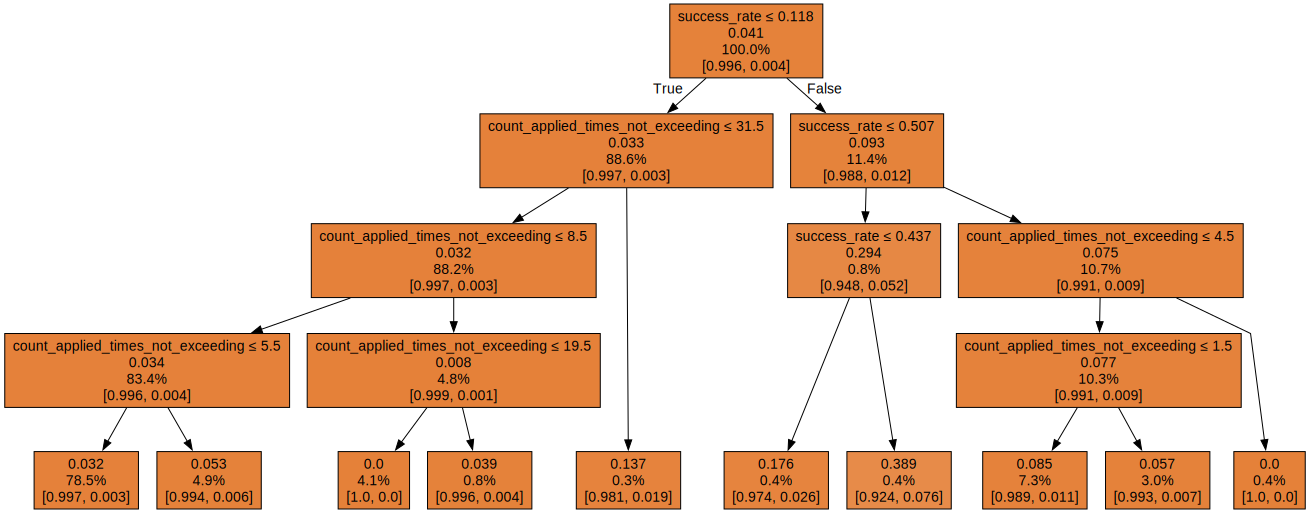

In [126]:

# train_data = modelling_df[modelling_df['sum_payments_within_168_hours'] <= 900][regressors_all + ['new_disputer_30d']].fillna(0)
train_data = modelling_df[modelling_df['count_applied_times_not_exceeding'] > 0][regressors_all + ['new_disputer_30d']].fillna(0)
# train_data = df_7d[regressors_all + ['new_disputer_30d']].fillna(0)
X_train, y_train = train_data.drop(columns = ['new_disputer_30d']), train_data['new_disputer_30d'] 

criterion = 'log_loss' 
depth = 4
leaf_size = 100

clf = create_model(criterion, depth, leaf_size)
clf.fit(X_train, y_train)
clf = clf[0]

dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = X_train.columns
                           # ,  feature_names = cols
                           # ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)

In [73]:
train_data[train_data['success_rate'] < 0] 
train_data[train_data['success_rate'] > 0][train_data['success_rate'] < 1]['new_disputer_30d'].mean()
train_data[train_data['success_rate'] > 0][train_data['success_rate'] < 0.8]['new_disputer_30d'].mean()

0.03614457831325301

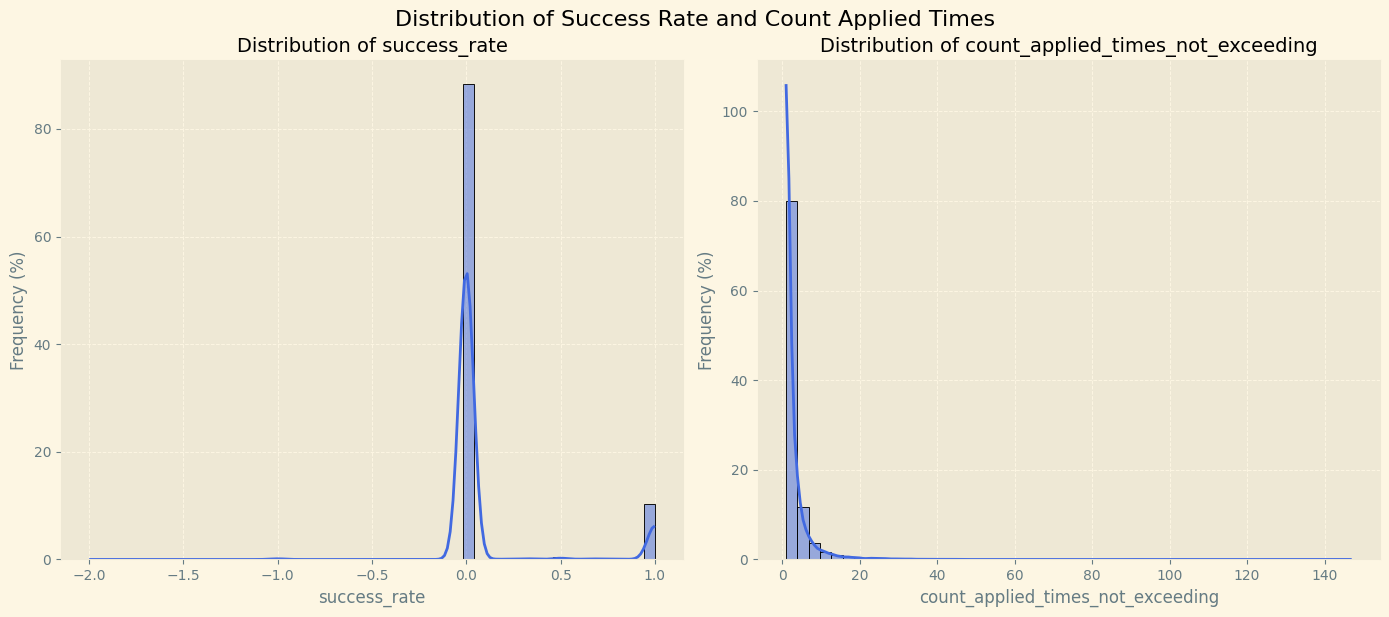

In [227]:
# Set the style to a professional look
plt.style.use('Solarize_Light2')  # Consulting-friendly and scientific style

# Function to plot the distribution of both columns
def plot_distributions(df, columns):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, column in zip(axes, columns):
        sns.histplot(df[column], bins=50, kde=True, ax=ax, color='royalblue', stat='percent')
        ax.set_title(f'Distribution of {column}', fontsize=14)
        ax.set_xlabel(column, fontsize=12)
        ax.set_ylabel('Frequency (%)', fontsize=12)
        ax.grid(True, linestyle='--', linewidth=0.7)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.suptitle('Distribution of Success Rate and Count Applied Times', fontsize=16, y=1.02)
    plt.show()

# Call the function with the dataset and the columns to plot
plot_distributions(train_data[train_data['count_applied_times_not_exceeding'] > 0], ['success_rate', 'count_applied_times_not_exceeding'])


In [83]:
train_data['count_applied_times_not_exceeding'].min()

1

In [136]:

# Step 1: Create the new group column based on success_rate
def categorize_success_rate(success_rate):
    if success_rate <= 0:
        return '0'
    elif success_rate < 1:
        return '(0, 1)'
    else:
        return '1'

train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)

def create_quantile_labels(series, n_quantiles):

    return pd.qcut(
        series, 
        q=n_quantiles, 
        labels=[f'Quantile {i + 1}' for i in range(n_quantiles)],
        duplicates='drop'  # Avoid duplicate bin edges
    )

# Example usage:
train_data['quantiles'] = create_quantile_labels(train_data['count_applied_times_not_exceeding'], 5)  # Create 5 quantiles

# Step 2: Plot the average of 'new_disputer_30d' for each group of 'success_rate_group' and 'count_applied_times_not_exceeding_quantile'
def plot_success_rate_vs_disputer(df):
    plt.figure(figsize=(12, 6))
    
    # Plot each 'count_applied_times_not_exceeding_quantile' group with a different line
    for group in df['quantiles'].unique():
        group_data = df[df['quantiles'] == group]
        sns.lineplot(
            data=group_data, 
            x='success_rate_group', 
            y='new_disputer_30d', 
            label=f'{group} Quantile',
            marker='o'
        )

    # Set titles and labels
    plt.title('Average new_disputer_30d by Success Rate Group and Count Applied Times Quantile', fontsize=16)
    plt.xlabel('Success Rate Group', fontsize=12)
    plt.ylabel('Average new_disputer_30d', fontsize=12)
    plt.legend(title='Count Applied Times Quantile', loc='best')
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.show()

# Step 3: Call the function to plot the data
plot_success_rate_vs_disputer(train_data)


ValueError: Bin labels must be one fewer than the number of bin edges

In [131]:
train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)


In [140]:
train_data_filtered['success_rate_group'].astype(float)

ValueError: could not convert string to float: '(0, 1)'

In [148]:
train_data.groupby('success_rate_group')['new_disputer_30d'].mean()
train_data_filtered = train_data[train_data['success_rate_group'] == '(0, 1)']

train_data_filtered['success_rate_group_quantiles'] = create_quantile_labels(train_data_filtered['success_rate'].astype(float), 4)  # Create 5 quantiles

# train_data_filtered.groupby('success_rate_group_quantiles')['new_disputer_30d'].mean()

train_data_filtered.groupby('success_rate_group_quantiles').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()


,success_rate_group_quantiles,mean_new_disputer,sum_new_disputer
0,Quantile 1,0.027778,3
1,Quantile 2,0.070866,9
2,Quantile 3,0.000000,0
3,Quantile 4,0.000000,0


In [155]:
train_data_filtered['count_applied_times_not_exceeding']

0         2
1         1
2         4
3         1
4         2
         ..
171273    2
171738    1
171796    2
171801    2
172028    1
Name: count_applied_times_not_exceeding, Length: 27236, dtype: int64

In [224]:
import pandas as pd

# Step 1: Filter the DataFrame for success_rate_group '0'
train_data_filtered = train_data[train_data['success_rate_group'] == '0'].copy()

# Step 2: Ensure the count_applied_times_not_exceeding column is numeric
train_data_filtered['count_applied_times_not_exceeding'] = pd.to_numeric(
    train_data_filtered['count_applied_times_not_exceeding'], errors='coerce'
)

# Step 3: Drop NaN values from the relevant column
train_data_filtered.dropna(subset=['count_applied_times_not_exceeding'], inplace=True)

# Step 4: Calculate the number of unique values
n_unique = train_data_filtered['count_applied_times_not_exceeding'].nunique()
n_quantiles = min(3, n_unique)  # Set to the minimum of requested quantiles or unique values

# Create quantile labels
def create_quantile_labels(series, n_quantiles):
    # If there are not enough unique values, return a series of None
    if len(series) < 2 or n_quantiles < 1:  
        return pd.Series([None] * len(series))
    
    # Use pd.qcut with duplicates='drop'
    return pd.qcut(
        series,
        q=n_quantiles,
        labels=[f'Quantile {i + 1}' for i in range(n_quantiles)],
        duplicates='drop'  # Avoid duplicate bin edges
    )

# Apply the quantile creation function
train_data_filtered['quantis'] = create_quantile_labels(train_data_filtered['count_applied_times_not_exceeding'], 2)

# Group by the quantile labels and calculate mean and sum of new_disputer_30d
summary_stats = train_data_filtered.groupby('count_applied_times_not_exceeding').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()

# Display the results
summary_stats


,count_applied_times_not_exceeding,mean_new_disputer,sum_new_disputer
0,1,0.003403,44
1,2,0.004062,24
2,3,0.003079,8
3,4,0.001157,2
4,5,0.003093,3
...,...,...,...
71,111,0.000000,0
72,119,0.000000,0
73,129,0.000000,0
74,140,1.000000,2


In [226]:
# Step 1: Convert the column to integer
train_data_filtered = train_data[train_data['success_rate_group'] == '0'].copy()+
train_data_filtered['count_applied_times_not_exceeding'] = train_data_filtered['count_applied_times_not_exceeding'].astype(int)

# Step 2: Apply the condition to transform the values
train_data_filtered['count_applied_times_not_exceeding'] = train_data_filtered['count_applied_times_not_exceeding'].apply(
    lambda x: ">4" if x >= 4 else x
)

train_data_filtered.groupby('count_applied_times_not_exceeding').agg(
    mean_new_disputer=('new_disputer_30d', 'mean'),
    sum_new_disputer=('new_disputer_30d', 'sum')
).reset_index()


,count_applied_times_not_exceeding,mean_new_disputer,sum_new_disputer
0,1,0.003403,44
1,2,0.004062,24
2,3,0.003079,8
3,>4,0.002932,17


In [222]:
train_data_filtered['count_applied_times_not_exceeding'].sample(5)

73238     3
71507     1
724      11
1125      1
17802     1
Name: count_applied_times_not_exceeding, dtype: int64

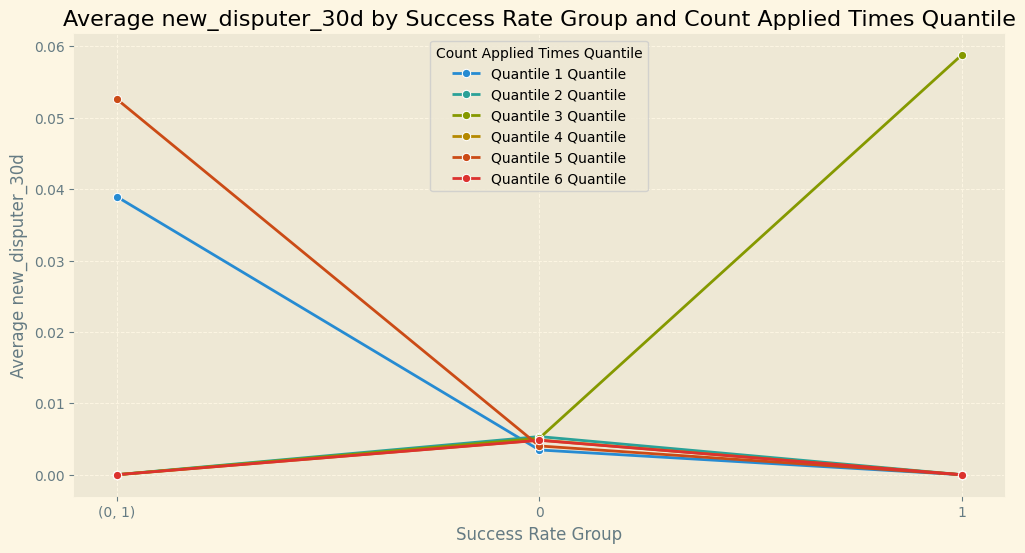

In [120]:
def categorize_success_rate(success_rate):
    if success_rate <= 0:
        return '0'
    elif success_rate < 1:
        return '(0, 1)'
    else:
        return '1'

train_data['success_rate_group'] = train_data['success_rate'].apply(categorize_success_rate)

def create_quantile_labels(series, n_quantiles):
    series = series.dropna()
    unique_values = series.nunique()
    n_quantiles = min(n_quantiles, unique_values)
    quantiles = pd.qcut(series, q=n_quantiles, labels=False, duplicates='drop')
    unique_quantiles = quantiles.unique()
    labels = [f'Quantile {i + 1}' for i in range(len(unique_quantiles))]
    quantile_labels = pd.Series(labels, index=unique_quantiles)
    return quantile_labels[quantiles].reset_index(drop=True)

# Create quantiles for count_applied_times_not_exceeding
train_data['quantiles'] = create_quantile_labels(train_data['count_applied_times_not_exceeding'], 20)

# Step 2: Calculate average new_disputer_30d for each combination of success_rate_group and quantiles
grouped_data = (train_data
                .groupby(['success_rate_group', 'quantiles'])
                .agg(average_new_disputer=('new_disputer_30d', 'mean'))
                .reset_index())

# Step 3: Plot the average of 'new_disputer_30d' for each group of 'success_rate_group' and 'quantiles'
def plot_success_rate_vs_disputer(grouped_data):
    plt.figure(figsize=(12, 6))

    # Plot each 'count_applied_times_not_exceeding_quantile' group with a different line
    for group in grouped_data['quantiles'].unique():
        group_data = grouped_data[grouped_data['quantiles'] == group]
        
        # Ensure there is data to plot
        if not group_data.empty:
            sns.lineplot(
                data=group_data, 
                x='success_rate_group', 
                y='average_new_disputer', 
                label=f'{group} Quantile',
                marker='o'
            )

    # Set titles and labels
    plt.title('Average new_disputer_30d by Success Rate Group and Count Applied Times Quantile', fontsize=16)
    plt.xlabel('Success Rate Group', fontsize=12)
    plt.ylabel('Average new_disputer_30d', fontsize=12)
    plt.legend(title='Count Applied Times Quantile', loc='best')
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.show()

# Step 4: Call the function to plot the data
plot_success_rate_vs_disputer(grouped_data)


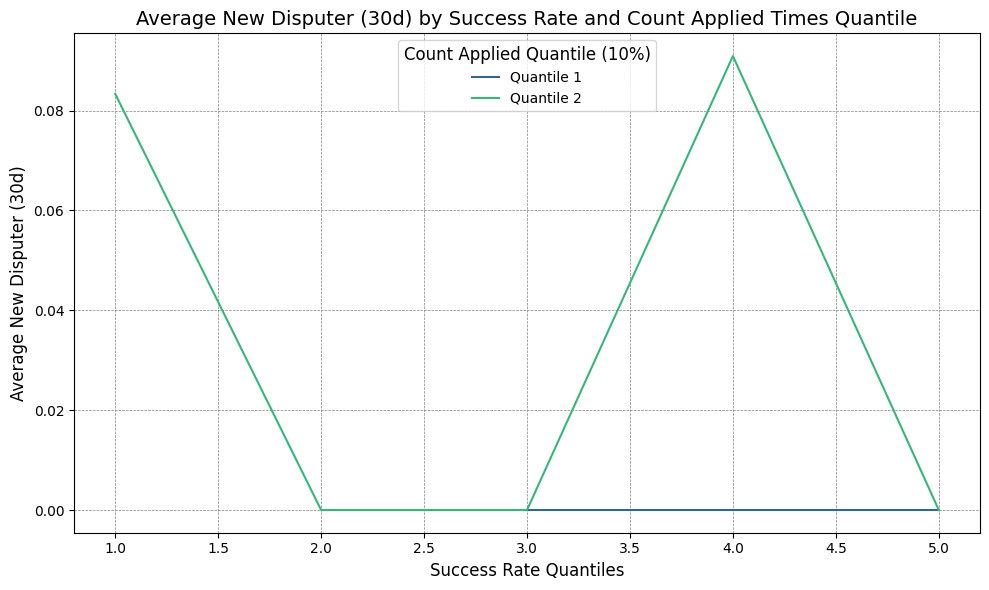

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create the desired chart
def plot_success_rate_vs_disputer(df, x_column, y_column, color_column, num_quantiles, drop_duplicates=True):
    # Option to handle non-unique bin edges by ranking or dropping duplicates
    if drop_duplicates:
        df = df.drop_duplicates(subset=[x_column, color_column])

    # Calculate quantiles for success_rate (X-axis) and count_applied_times_not_exceeding (Color)
    df['success_rate_quantile'] = pd.qcut(df[x_column].rank(method='first'), q=5, labels=np.arange(1, 6))  # 10 quantiles for success_rate
    df['count_applied_quantile'] = pd.qcut(df[color_column].rank(method='first'), q=num_quantiles, labels=np.arange(1, num_quantiles + 1))  # 8 quantiles for color

    # Group by success_rate_quantile and count_applied_quantile, and calculate the mean of new_disputer_30d
    grouped = df.groupby(['success_rate_quantile', 'count_applied_quantile'])[y_column].mean().reset_index()

    # Pivot the data to get the format needed for plotting
    pivot_df = grouped.pivot(index='success_rate_quantile', columns='count_applied_quantile', values=y_column)

    # McKinsey-style and scientific-style chart setup
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", num_quantiles)  # Use a scientific color palette

    # Plot each quantile as a separate line
    for col in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[col], label=f'Quantile {col}', color=colors[int(col)-1])

    # Add labels and title
    plt.title('Average New Disputer (30d) by Success Rate and Count Applied Times Quantile', fontsize=14)
    plt.xlabel('Success Rate Quantiles', fontsize=12)
    plt.ylabel('Average New Disputer (30d)', fontsize=12)

    # Add grid, legend, and format
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    plt.legend(title='Count Applied Quantile (10%)', title_fontsize=12, fontsize=10)
    
    # Set valid style
    plt.style.use('Solarize_Light2')  # Valid style name

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage (assuming merged_df is the DataFrame)
plot_success_rate_vs_disputer(train_data, 'success_rate', 'new_disputer_30d', 'count_applied_times_not_exceeding', num_quantiles=2)


### Some confirmation

- Why do you have negative values? 

- You know that non-integer success rates are not necessarily giving high dispute rates

- 0% is better than 1%, is 0% dangerous if applications have been made more times

- Is there any insight within non-integer rates?

# Planification of rules for reporting 

In [ ]:
# According to the map, you only should be lookoing at the count_applied_times_not_exceeding. Because the numbers in terms of success rate don't make much sense 